---
## Assumptions and rules
---

Use a simple, consistent backtest setup:
- Trade at **next day close** (i.e., use yesterday’s signal as today’s position)
- Ignore transaction costs and slippage (unless you choose to add them)
- Long/cash only for Part A
- Extensions may optionally include shorting, but it is not required

### What “backtest” means here
A backtest simulates how your portfolio would have performed historically if you had followed your trading rules mechanically.


In [ ]:
# Import your functions

---
# Part A: Core Task — Implement One Momentum Strategy
---




---
## Step 1: Libraries 
---

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import quantstats as qs
import warnings

---
## Step 2: Load price data
---


In [2]:
# Prepare Apple data into a dataframe
def download_stock_data(ticker, start_date):
    data = yf.download(
        ticker,
        start=start_date,
        auto_adjust=True, #prices adjusted for dividends and splits
        progress=False
    )
    return data['Close'] 

# Download Apple data
prices = download_stock_data("AAPL", "2015-01-01") #close prices series indexed by date


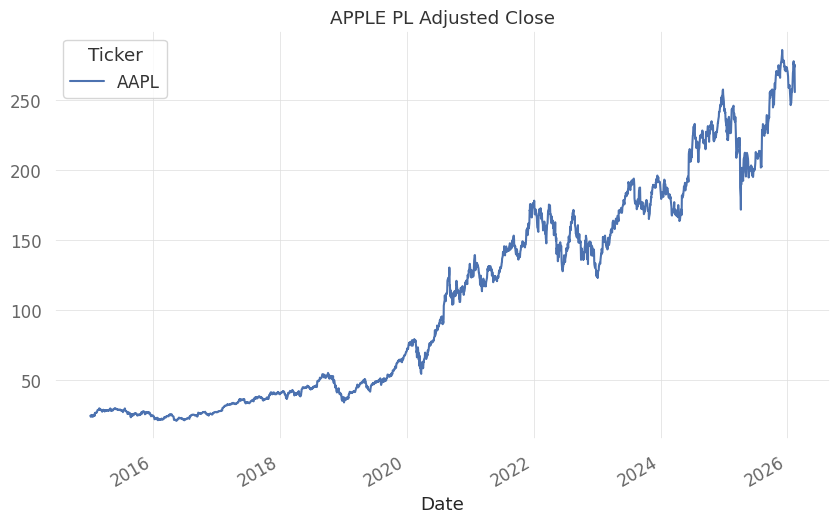

In [3]:
# Display the visualisation of the data
prices.plot(title="APPLE PL Adjusted Close")
plt.show()

---
## Step 2: Karthik - Backtest framework
---

You will generate a `signal`:
- `1` = long
- `0` = cash

The backtest uses `position = signal.shift(1)` to avoid look-ahead bias.


In [ ]:
# Define the function which will develop

---
## Step 3: Implement 3 Strategies
---




---
### Arin: ROC Threshold
---

**Rule:** Buy if the price increased by more than a threshold over the last `roc_n` days.


In [ ]:
# Develop the ROC indicator

---
### Adrian: Moving Average Crossover
---

**Rule:** Buy when a fast moving average is above a slow moving average.


In [ ]:
# Develop the Moving Average Crossover indicator

---
### Piraveen: MACD Signal
---

**Rule:** Buy when MACD is above its signal line.
- `MACD = EMA(12) - EMA(26)`
- `Signal line = EMA(9) of MACD`


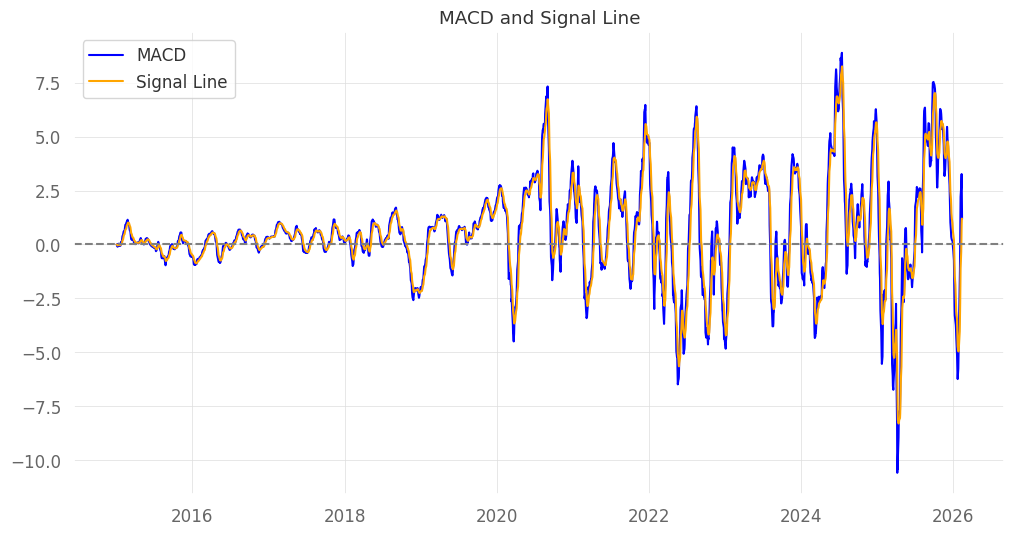

Bullish signals: Ticker
AAPL    100
dtype: int64
Bearish signals: Ticker
AAPL    101
dtype: int64


In [4]:
#Compute MACD 

def calculate_macd(prices, fast_span=12, slow_span=26, signal_span=9):
    # Calculate MACD components
    ema_fast = prices.ewm(span=fast_span, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_span, adjust=False).mean()
    macd_line = ema_fast - ema_slow

    # Smooth the MACD line to get the signal line and calculate the histogram
    signal_line = macd_line.ewm(span=signal_span, adjust=False).mean()
    histogram = macd_line - signal_line

    return macd_line, signal_line, histogram #returns one object as a tuple (ordered container of three objects) of three series: macd_line, signal_line, histogram

# Calculate MACD
macd, signal, histogram = calculate_macd(prices) # tuple unpacking, internally macd = calculate_macd(prices)[0], signal = calculate_macd(prices)[1], histogram = calculate_macd(prices)[2]

# Plot MACD and Signal line
plt.figure(figsize=(12, 6))
plt.plot(macd, label="MACD", color="blue")
plt.plot(signal, label="Signal Line", color="orange")

plt.axhline(0, color="gray", linestyle="--") # Add a horizontal line at y=0 for reference
plt.title("MACD and Signal Line")
plt.legend()
plt.show()

# Generate trading signals by shifting yesterday's MACD and Signal values to indicate crossovers
bullish_signals = ((macd > signal) & (macd.shift(1) <= signal.shift(1))).sum() # Count the number of times the MACD line crosses above the Signal line (bullish crossover) -> crossover due to macd.shift(1) and signal.shift(1) are used to compare the current values of macd and signal with their previous values to identify crossovers.
bearish_signals = ((macd < signal) & (macd.shift(1) >= signal.shift(1))).sum() # Count the number of times the MACD line crosses below the Signal line (bearish crossover)

print(f"Bullish signals: {bullish_signals}")
print(f"Bearish signals: {bearish_signals}")

#### **MACD visually captures volatility + trend strength, not just direction.**

- The blue line is MACD, which measures short term momentum relative to the longer term trend.

- The orange line is the signal line, a smoothed version of MACD that represents the recent average level of momentum.

- The dashed zero line separates bullish and bearish momentum regimes.

**Explanation**

- When MACD crosses above the signal line, momentum is strengthening upward, generating a bullish signal.

- When MACD crosses below the signal line, momentum is weakening, generating a bearish signal.

- Larger swings indicate stronger momentum or higher volatility, which is especially visible after 2020.

**Why it is useful**

- It filters noisy price movements into momentum signals.

- It helps time entries and exits by identifying momentum accelerations and reversals rather than predicting price levels.

#### **Backtest framework over past 10 years vs Buy-Hold Strategy**

ticker: AAPL
start: 2015-01-01
end: 2026-02-13
initial_capital: 1000000.000000
ending_value_strategy: 7056875.906502
ending_value_buyhold: 10562918.231155
profit_strategy: 6056875.906502
profit_pct_strategy: 6.056876
max_drawdown_strategy: -0.270335
trades: 199.000000
fee_rate_per_trade: 0.000500
strategy_name: macd_strategy
strategy_params: {'fast_span': 12, 'slow_span': 26, 'signal_span': 9}


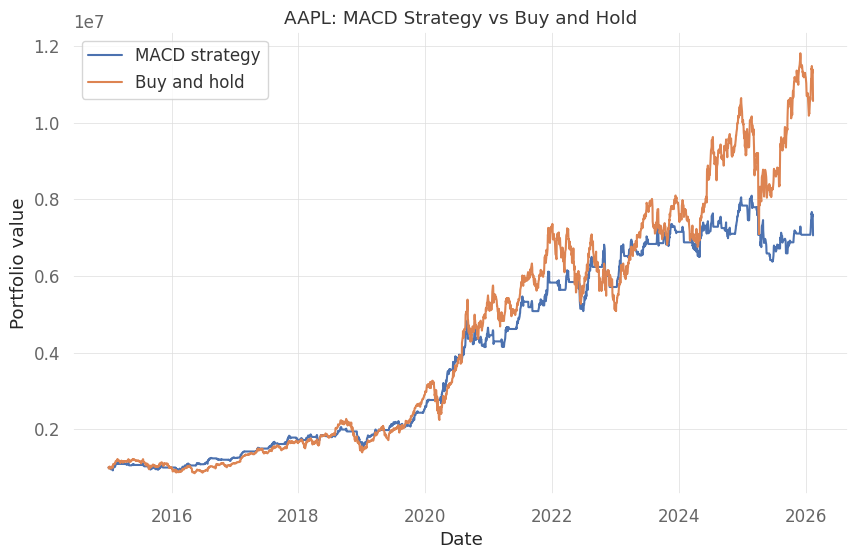

In [6]:
# 1) Import your backtest engine (edit the module name to match your file)
from backtest_function import run_backtest
import pandas as pd
import matplotlib.pyplot as plt


# 2) Define your MACD strategy function (returns RAW position, no shifting here)
def macd_strategy(prices: pd.Series, data: pd.DataFrame, params: dict) -> pd.Series:
    fast = int(params.get("fast_span", 12))
    slow = int(params.get("slow_span", 26))
    sig  = int(params.get("signal_span", 9))

    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()

    macd = ema_fast - ema_slow
    signal = macd.ewm(span=sig, adjust=False).mean()

    # long-only: 1 when MACD > signal else 0
    return (macd > signal).astype(float)

# 3) Run the backtest
res = run_backtest(
    ticker="AAPL",
    start="2015-01-01",
    strategy_fn=macd_strategy,
    strategy_params={"fast_span": 12, "slow_span": 26, "signal_span": 9},
    initial_capital=1_000_000.0,
    fee_rate_per_trade=0.0005,
    shift_signals_by=1,   # avoids look-ahead bias
    auto_adjust=True
)

# 4) Print results
for k, v in res.results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v}")

# 5) Plot equity curves
plt.figure()
plt.plot(res.equity_strategy, label="MACD strategy")
plt.plot(res.equity_buyhold, label="Buy and hold")
plt.title("AAPL: MACD Strategy vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.show()

#### **Reporting on graph**    

The orange line (buy and hold) grows faster in strong bull markets

The blue line (MACD) is smoother but **lags** badly when Apple trends strongly upward

Key visual insights:

*1) 2019–2021 bull market*

- Buy and hold explodes upward

- MACD repeatedly exits and re-enters

- This causes missed upside

*2)2022 market crash*

- Buy and hold falls hard

- MACD falls much less

*3) Post-2023 recovery*

- Buy and hold again dominates

- MACD stays cautious and under-participates

#### **COVID Period Analysis**

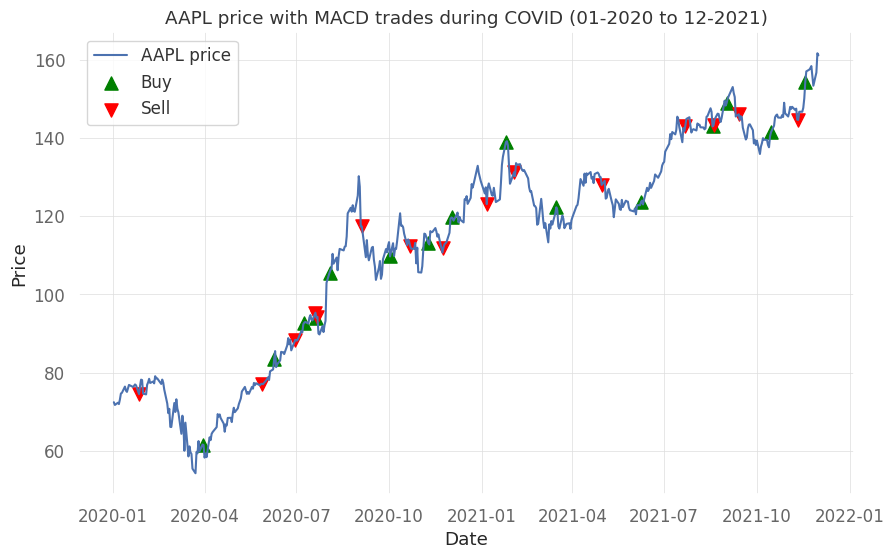

In [7]:
# Analyze COVID period (2020-01-01 to 2021-12-01)
covid_start = "2020-01-01"
covid_end = "2021-12-01"

# Slice data for COVID period
px_covid = res.prices.loc[covid_start:covid_end]
pos_covid = res.position.reindex(px_covid.index).fillna(0).astype(int)

# Get entry and exit dates
changes = pos_covid.diff().fillna(0)
buy_dates = changes[changes == 1].index
sell_dates = changes[changes == -1].index

# Visualize
plt.figure()
plt.plot(px_covid.index, px_covid.values, label="AAPL price")
plt.scatter(buy_dates, px_covid.loc[buy_dates], marker="^", s=90, label="Buy", color='green')
plt.scatter(sell_dates, px_covid.loc[sell_dates], marker="v", s=90, label="Sell", color='red')
plt.title("AAPL price with MACD trades during COVID (01-2020 to 12-2021)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

#### **Final Quant (See File Named MACD Performance Report)**

In [ ]:
warnings.filterwarnings('ignore')

# Calculate returns
strategy_returns = res.equity_strategy.pct_change().dropna()
benchmark_returns = res.equity_buyhold.pct_change().dropna()

# Align dates
df = pd.concat([strategy_returns, benchmark_returns], axis=1).dropna()

# Generate HTML report
qs.reports.html(
    df.iloc[:, 0],
    benchmark=df.iloc[:, 1],
    output="performancereportMACD.html",
    title="Strategy vs Benchmark"
)

print("Done: performancereportMACD.html")

#### **Key takeaway from report**

The MACD strategy does not beat buy and hold AAPL in raw returns, but it materially improves risk-adjusted performance and downside control.

1) **Lower returns, lower risk**
 - Buy and hold AAPL delivers higher cumulative return and CAGR (about 1004% and 24.25%) than the MACD strategy (about 655% and 20.05%). However, the strategy earns these returns with much lower volatility and shallower drawdowns

2) **Superior risk adjusted metrics**
 - The strategy has a higher Sharpe and Sortino, higher Omega, higher Calmar, and better Ulcer and Serenity indices. This means more return per unit of risk and pain, even though absolute returns are lower

3) **Limitation: Opportunity cost in strong bull markets**
 - The strategy underperforms badly in sustained momentum regimes (2017, 2019, 2021, 2023, 2024) because it exits too early and stays out of the market roughly 45% of the time 

4) **Limitation: Lag and whipsaw from backward looking signals**
 - MACD reacts after trends change. In sideways or slowly trending regimes this causes false exits and re entries, lowering expected returns and profit ratio

